# クラスター分析: アンケートデータ分析の2歩目
## 0. はじめに
### 0.1. 目的
缶コーヒー市場の市場調査の一貫として，アンケートデータから顧客をクラスタリングして，顧客像を掴みましょう！また，Datactのプロジェクトやマーケティング全般にどのように活かすことが出来るか考えてみましょう！
### 0.2. データ
8つのコーヒーの嗜好に関するアンケート項目(q，5段階評価)と3つのデモグラフィック項目(F)で構成されています．80人分の回答が集まっています．

＜アンケート項目＞
- q1 味や、品質にこだわる
- q2 ときと場合により、飲みわける
- q3 気に入ったブランドはない
- q4 人よりよく知っている
- q5 ひとより多く飲む
- q6 特に気にしない
- q7 新製品が出ると試してみる
- q8 好きなブランドを人に勧めることがある
- F1 年齢
 - 1: ~20
 - 2: 21~25
 - 3: 26~30
 - 4: 31~35
 - 5: 36~40
 - 6: 41~60
 - 7: 61~
- F2 性別
 - 1: 男性
 - 2: 女性
- F3 職業
 - 1: 自営業
 - 2: 会社員
 - 3: アルバイト
 - 4: 学生
 - 5: 専業主婦
 - 6: 無職
 - 7: その他

### 0.3. 分析の流れ
**[1. データの前処理](#first-bullet)**
: 分析に入るまでの準備です


**[2. 非階層クラスター分析](#second-bullet)**
: クラスタリングしていきます

**[3. 結果の解釈](#third-bullet)**
: クラスターごとの特徴を可視化していきます

**[4. 因子分析×クラスター分析](#fourth-bullet)**
: 因子でクラスタリングしてみます


## 1. データの前処理 <a class="anchor" id="first-bullet"></a>
### 1.1. データの読み込み
いつも通りですね．```pd.read_csv()```で読み込んで，```head()```でデータを見てみましょう．

In [1]:
import pandas as pd
df = pd.read_csv('COFFEE.csv')
df.head()

/Users/k.fukada/.local/share/virtualenvs/data_science-tXjswaqR/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,ID,q1,q2,q3,q4,q5,q6,q7,q8,F1,F2,F3
0,1,4,4,2,3,2,2,4,4,6,2,5
1,2,5,3,5,3,1,5,1,1,2,1,4
2,3,5,1,1,5,4,1,5,5,5,1,2
3,4,4,4,3,2,3,3,3,2,2,2,3
4,5,4,4,5,2,2,2,2,2,4,2,3


データの情報を確認しておきます．```info```関数を使うと，その名の通りデータの情報をみることが出来ます．

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      80 non-null     int64
 1   q1      80 non-null     int64
 2   q2      80 non-null     int64
 3   q3      80 non-null     int64
 4   q4      80 non-null     int64
 5   q5      80 non-null     int64
 6   q6      80 non-null     int64
 7   q7      80 non-null     int64
 8   q8      80 non-null     int64
 9   F1      80 non-null     int64
 10  F2      80 non-null     int64
 11  F3      80 non-null     int64
dtypes: int64(12)
memory usage: 7.6 KB


### 1.2. 必要なデータの抽出
クラスタリングに使うデータを抽出していきます．データの**行と列**で抽出を行う時は，```loc```関数や```iloc```関数を使います．[このサイト](https://kojimanotech.com/2019/08/08/174/)で詳しく説明されています．簡単に説明すると，```loc```関数は行と列の**名前**で，```iloc```関数は行と列の**番号**でデータを抽出します．行、列のどちらかを特に指定しない場合は```:```と書いておきます．

In [35]:
df_cluster = df.iloc[:,1:9]
df_cluster.head()

,q1,q2,q3,q4,q5,q6,q7,q8
0,4,4,2,3,2,2,4,4
1,5,3,5,3,1,5,1,1
2,5,1,1,5,4,1,5,5
3,4,4,3,2,3,3,3,2
4,4,4,5,2,2,2,2,2


### 1.3. クラスター分析の準備
分析の都合上，データフレーム形式では分析出来ないので，行列形式に変換します．簡単にいうと，データフレームの構成要素である**column(列の名前;今回だとq1, q2...)・index(行の名前;0, 1, 2...)・value(データの値;1~5)**の3つのうち，**value**だけにしたいのです．

In [36]:
array = df_cluster.values
array

array([[4, 4, 2, 3, 2, 2, 4, 4],
       [5, 3, 5, 3, 1, 5, 1, 1],
       [5, 1, 1, 5, 4, 1, 5, 5],
       [4, 4, 3, 2, 3, 3, 3, 2],
       [4, 4, 5, 2, 2, 2, 2, 2],
       [3, 3, 3, 1, 1, 1, 1, 1],
       [3, 3, 2, 2, 2, 3, 2, 2],
       [4, 3, 2, 2, 1, 2, 2, 2],
       [4, 4, 3, 2, 2, 4, 2, 1],
       [4, 4, 4, 2, 2, 2, 2, 4],
       [3, 3, 4, 2, 3, 3, 3, 1],
       [5, 5, 1, 4, 4, 3, 5, 4],
       [5, 4, 2, 3, 3, 2, 5, 5],
       [3, 2, 3, 2, 2, 3, 4, 1],
       [2, 3, 4, 2, 5, 4, 3, 2],
       [3, 2, 3, 1, 2, 4, 4, 2],
       [4, 1, 4, 3, 1, 4, 5, 2],
       [4, 1, 4, 3, 1, 3, 1, 2],
       [4, 2, 3, 2, 3, 3, 3, 3],
       [5, 4, 5, 3, 3, 1, 5, 4],
       [5, 4, 1, 4, 2, 1, 4, 3],
       [5, 3, 1, 2, 1, 1, 3, 3],
       [5, 4, 3, 1, 1, 4, 1, 1],
       [4, 2, 3, 2, 2, 4, 3, 2],
       [4, 5, 2, 2, 2, 3, 3, 2],
       [4, 2, 3, 2, 2, 3, 4, 2],
       [4, 4, 4, 3, 1, 3, 2, 2],
       [4, 4, 3, 2, 3, 2, 2, 1],
       [4, 3, 2, 3, 4, 2, 2, 2],
       [4, 2, 5, 2, 2, 5, 2, 1],
       [2,

## 2. 非階層クラスター分析 <a class="anchor" id="second-bullet"></a>
k-meansアルゴリズムでクラスター分析を実行する際には，```scikit-learn```に入っている```Kmeans```というコマンドを使用します．こちらで指定する必要のある部分は**①クラスターの数(n_clusters)**と**②乱数(random_state)**の2つです．特に②の乱数については設定しておいた方が良いです．指定しないと、分析を実行するたびにクラスターの番号が変わってしまうので厄介です．詳しい説明は[こちら](https://pythondatascience.plavox.info/scikit-learn/%E3%82%AF%E3%83%A9%E3%82%B9%E3%82%BF%E5%88%86%E6%9E%90-k-means)にまとまっています．

ここまででクラスター分析の準備が整いました！早速，実行してみたいと思います．```fit_predict```コマンドを実行すると，クラスター分析の結果を返してくれます．

In [37]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 4, random_state = 1)
pred = km.fit_predict(array)
pred

array([2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 3, 3, 3, 1, 3, 2, 2, 2,
       0, 3, 0, 3, 0, 0, 0, 1, 1, 3, 1, 3, 0, 0, 0, 1, 1, 0, 2, 1, 2, 0,
       3, 2, 2, 1, 2, 3, 2, 3, 3, 0, 1, 2, 2, 0, 0, 0, 3, 0, 3, 3, 0, 2,
       2, 3, 1, 2, 3, 3, 0, 0, 1, 0, 0, 2, 1, 2], dtype=int32)

80人に対して0,1,2,3の4つのクラスター番号が割り振られました．この結果をもとのデータに結合して行きます．今回は新しくcluster_idという列を作り，結果を格納しています．

In [38]:
df['cluster'] = pred
df.head()

,ID,q1,q2,q3,q4,q5,q6,q7,q8,F1,F2,F3,cluster
0,1,4,4,2,3,2,2,4,4,6,2,5,2
1,2,5,3,5,3,1,5,1,1,2,1,4,1
2,3,5,1,1,5,4,1,5,5,5,1,2,2
3,4,4,4,3,2,3,3,3,2,2,2,3,0
4,5,4,4,5,2,2,2,2,2,4,2,3,0


## 3. 結果の解釈 <a class="anchor" id="third-bullet"></a>
### 3.1. 人数
まずは，クラスターの人数構成比を調べてみます．ここでは，ユニークな要素をカウントする際によく使われる```value_counts()```関数を使用しています．詳しい説明は[こちら](https://note.nkmk.me/python-pandas-value-counts/)から．色々な場面で使えて便利です．

In [39]:
df.cluster.value_counts()

0    28
2    20
3    19
1    13
Name: cluster, dtype: int64

### 3.2. 嗜好
ここから，グループごとにアンケート項目の平均得点算出し，各グループの特徴を明らかにしていきましょう！グループごとに集計する際には```groupby()```という関数が役立ちます．()の中にグループが含まれている列の指定を，その後に集計方法を指定します．詳しくは[こちら](https://qiita.com/propella/items/a9a32b878c77222630ae)を参考に．

In [40]:
df.groupby('cluster').mean()

,ID,q1,q2,q3,q4,q5,q6,q7,q8,F1,F2,F3
cluster,,,,,,,,,,,,
0,37.214286,3.607143,3.642857,3.178571,2.000000,1.928571,2.714286,2.107143,1.750000,2.750000,1.500000,3.285714
1,43.000000,2.923077,2.076923,4.538462,1.615385,1.384615,4.076923,1.769231,1.230769,2.461538,1.230769,3.384615
2,42.150000,4.650000,4.000000,2.100000,3.100000,2.550000,1.800000,4.300000,3.700000,2.700000,1.350000,3.600000
3,41.894737,3.789474,2.210526,3.263158,2.105263,2.526316,3.473684,3.842105,2.631579,3.315789,1.368421,3.789474


###### ```reset_index()```を最後につけることで，見慣れているデータフレームの形に戻すことが出来ます．

In [41]:
df.groupby('cluster').mean().reset_index()

,cluster,ID,q1,q2,q3,q4,q5,q6,q7,q8,F1,F2,F3
0,0,37.214286,3.607143,3.642857,3.178571,2.000000,1.928571,2.714286,2.107143,1.750000,2.750000,1.500000,3.285714
1,1,43.000000,2.923077,2.076923,4.538462,1.615385,1.384615,4.076923,1.769231,1.230769,2.461538,1.230769,3.384615
2,2,42.150000,4.650000,4.000000,2.100000,3.100000,2.550000,1.800000,4.300000,3.700000,2.700000,1.350000,3.600000
3,3,41.894737,3.789474,2.210526,3.263158,2.105263,2.526316,3.473684,3.842105,2.631579,3.315789,1.368421,3.789474


アンケート項目のデータだけに絞りましょう．df_clusterとdfのcluster_id列を結合するのが一番早そうです．データフレーム同士を結合する際には，```concat()```という関数を使用します．詳細は[こちら](https://note.nkmk.me/python-pandas-concat/)を参照してください．列方向に結合するので，```axis = 1```です．

In [42]:
# df_clusterとdfのcluster_idという列のデータを結合してください
df_pre = pd.concat([log, df.cluster], axis=1)
df_pre.head()

,q1,q2,q3,q4,q5,q6,q7,q8,cluster
0,4,4,2,3,2,2,4,4,2
1,5,3,5,3,1,5,1,1,1
2,5,1,1,5,4,1,5,5,2
3,4,4,3,2,3,3,3,2,0
4,4,4,5,2,2,2,2,2,0


先ほどと同様にグループごとのアンケート項目の平均値をだしてみましょう！

In [43]:
df_mean = df_pre.groupby('cluster').mean()
df_mean.head()

,q1,q2,q3,q4,q5,q6,q7,q8
cluster,,,,,,,,
0,3.607143,3.642857,3.178571,2.000000,1.928571,2.714286,2.107143,1.750000
1,2.923077,2.076923,4.538462,1.615385,1.384615,4.076923,1.769231,1.230769
2,4.650000,4.000000,2.100000,3.100000,2.550000,1.800000,4.300000,3.700000
3,3.789474,2.210526,3.263158,2.105263,2.526316,3.473684,3.842105,2.631579



因子分析の時と同じように，```style.background_gradient```を使って，色付けしています．エクセルみたいな感じですね．詳しい使い方は[こちら](http://sinhrks.hatenablog.com/entry/2015/11/22/202640)．```light_palette```で色の指定をしています．色のパターンは[こちら](https://qiita.com/SaitoTsutomu/items/c79c9973a92e1e2c77a7)を参考にしてください，たくさんあります．

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
cm4 = sns.light_palette("skyblue", as_cmap=True)

df_mean.style.background_gradient(cmap = cm4)

,q1,q2,q3,q4,q5,q6,q7,q8
cluster,,,,,,,,
0,3.607143,3.642857,3.178571,2.000000,1.928571,2.714286,2.107143,1.750000
1,2.923077,2.076923,4.538462,1.615385,1.384615,4.076923,1.769231,1.230769
2,4.650000,4.000000,2.100000,3.100000,2.550000,1.800000,4.300000,3.700000
3,3.789474,2.210526,3.263158,2.105263,2.526316,3.473684,3.842105,2.631579


In [45]:
'''
q1 味や、品質にこだわる
q2 ときと場合により、飲みわける
q3 気に入ったブランドはない
q4 人よりよく知っている
q5 ひとより多く飲む
q6 特に気にしない
q7 新製品が出ると試してみる
q8 好きなブランドを人に勧めることがある
'''

'\nq1 味や、品質にこだわる\nq2 ときと場合により、飲みわける\nq3 気に入ったブランドはない\nq4 人よりよく知っている\nq5 ひとより多く飲む\nq6 特に気にしない\nq7 新製品が出ると試してみる\nq8 好きなブランドを人に勧めることがある\n'

### 3.3 デモグラフィック

次はデモグラフィックな情報について見ていきます．ここでは，必要なデータのみを抽出しています．

In [46]:
log_demo = df.iloc[:,9:13]
log_demo.head()

,F1,F2,F3,cluster
0,6,2,5,2
1,2,1,4,1
2,5,1,2,2
3,2,2,3,0
4,4,2,3,0


#### 3.3.1. 年齢
まずは集計をしていきます．今回はグループ・年齢の区分ごとに集計したいので，```groupby()```の中に2つ指定します．複数指定する時は[]の中で指定します．集計方法は要素の数のカウントなので，```size()```を使います．

In [47]:
log_demo.groupby(['cluster', 'F1']).size()

cluster  F1
0        1      1
         2     15
         3      7
         4      2
         5      1
         6      2
1        1      2
         2      7
         3      3
         7      1
2        2     14
         3      3
         5      1
         6      2
3        1      1
         2      9
         3      2
         4      2
         6      5
dtype: int64

圧倒的に見辛いですね．こういう時は可視化してやりましょう．このように数値ではなく**カテゴリカルなデータ**を可視化する時には```sns.countplot()```が役立ちます．指定する項目は**data(データ名)**, **x(x軸にくるデータ)**, **hue(グループごとに集計したい場合に指定)**です．詳しくは[こちら](https://pythondatascience.plavox.info/seaborn/%E6%A3%92%E3%82%B0%E3%83%A9%E3%83%95)

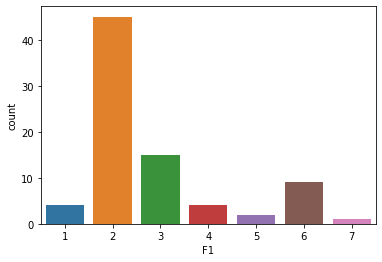

In [48]:
sns.countplot(data = log_demo, x='F1')

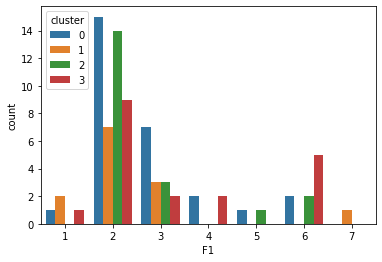

In [49]:
sns.countplot(data = log_demo, x='F1', hue='cluster')

#### 3.3.2. 性別

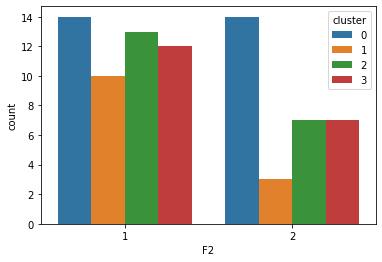

In [50]:
sns.countplot(data = log_demo, x='F2', hue='cluster')

#### 3.3.3. 職種

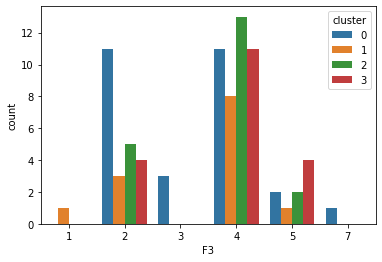

In [51]:
sns.countplot(data = log_demo, x='F3', hue='cluster')

## Groupwork: 20min
1. クラスターの個数を変えてみよう
2. クラスターごとの特徴を分析結果から考察してみよう
3. クラスター分析が活用出来そうな状況を考えてみよう

In [52]:
km = KMeans(n_clusters = 3, random_state = 1)
pred = km.fit_predict(array)
pred

array([0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1, 0, 2,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2, 0,
       0, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 0, 1, 0], dtype=int32)

In [53]:
df['cluster'] = pred
df.head()

,ID,q1,q2,q3,q4,q5,q6,q7,q8,F1,F2,F3,cluster
0,1,4,4,2,3,2,2,4,4,6,2,5,0
1,2,5,3,5,3,1,5,1,1,2,1,4,2
2,3,5,1,1,5,4,1,5,5,5,1,2,0
3,4,4,4,3,2,3,3,3,2,2,2,3,2
4,5,4,4,5,2,2,2,2,2,4,2,3,2


In [54]:
df.cluster.value_counts()

2    35
0    23
1    22
Name: cluster, dtype: int64

In [55]:
df.cluster.value_counts()

2    35
0    23
1    22
Name: cluster, dtype: int64

### 3.2. 嗜好
ここから，グループごとにアンケート項目の平均得点算出し，各グループの特徴を明らかにしていきましょう！グループごとに集計する際には```groupby()```という関数が役立ちます．()の中にグループが含まれている列の指定を，その後に集計方法を指定します．詳しくは[こちら](https://qiita.com/propella/items/a9a32b878c77222630ae)を参考に．

In [56]:
df.groupby('cluster').mean()

,ID,q1,q2,q3,q4,q5,q6,q7,q8,F1,F2,F3
cluster,,,,,,,,,,,,
0,43.086957,4.565217,3.782609,2.260870,3.086957,2.652174,1.956522,4.304348,3.782609,2.652174,1.304348,3.652174
1,37.909091,3.090909,1.636364,3.409091,1.863636,2.090909,3.500000,2.909091,1.954545,3.318182,1.363636,3.545455
2,40.428571,3.742857,3.657143,3.571429,1.914286,1.828571,3.114286,2.228571,1.685714,2.628571,1.457143,3.371429


###### ```reset_index()```を最後につけることで，見慣れているデータフレームの形に戻すことが出来ます．

In [57]:
df.groupby('cluster').mean().reset_index()

,cluster,ID,q1,q2,q3,q4,q5,q6,q7,q8,F1,F2,F3
0,0,43.086957,4.565217,3.782609,2.260870,3.086957,2.652174,1.956522,4.304348,3.782609,2.652174,1.304348,3.652174
1,1,37.909091,3.090909,1.636364,3.409091,1.863636,2.090909,3.500000,2.909091,1.954545,3.318182,1.363636,3.545455
2,2,40.428571,3.742857,3.657143,3.571429,1.914286,1.828571,3.114286,2.228571,1.685714,2.628571,1.457143,3.371429


アンケート項目のデータだけに絞りましょう．df_clusterとdfのcluster_id列を結合するのが一番早そうです．データフレーム同士を結合する際には，```concat()```という関数を使用します．詳細は[こちら](https://note.nkmk.me/python-pandas-concat/)を参照してください．列方向に結合するので，```axis = 1```です．

In [58]:
# df_clusterとdfのcluster_idという列のデータを結合してください
df_pre = pd.concat([log, df.cluster], axis=1)
df_pre.head()

,q1,q2,q3,q4,q5,q6,q7,q8,cluster
0,4,4,2,3,2,2,4,4,0
1,5,3,5,3,1,5,1,1,2
2,5,1,1,5,4,1,5,5,0
3,4,4,3,2,3,3,3,2,2
4,4,4,5,2,2,2,2,2,2


先ほどと同様にグループごとのアンケート項目の平均値をだしてみましょう！

In [59]:
df_mean = df_pre.groupby('cluster').mean()
df_mean.head()

,q1,q2,q3,q4,q5,q6,q7,q8
cluster,,,,,,,,
0,4.565217,3.782609,2.260870,3.086957,2.652174,1.956522,4.304348,3.782609
1,3.090909,1.636364,3.409091,1.863636,2.090909,3.500000,2.909091,1.954545
2,3.742857,3.657143,3.571429,1.914286,1.828571,3.114286,2.228571,1.685714



因子分析の時と同じように，```style.background_gradient```を使って，色付けしています．エクセルみたいな感じですね．詳しい使い方は[こちら](http://sinhrks.hatenablog.com/entry/2015/11/22/202640)．```light_palette```で色の指定をしています．色のパターンは[こちら](https://qiita.com/SaitoTsutomu/items/c79c9973a92e1e2c77a7)を参考にしてください，たくさんあります．

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
cm3 = sns.light_palette("skyblue", as_cmap=True)

df_mean.style.background_gradient(cmap = cm3)

,q1,q2,q3,q4,q5,q6,q7,q8
cluster,,,,,,,,
0,4.565217,3.782609,2.260870,3.086957,2.652174,1.956522,4.304348,3.782609
1,3.090909,1.636364,3.409091,1.863636,2.090909,3.500000,2.909091,1.954545
2,3.742857,3.657143,3.571429,1.914286,1.828571,3.114286,2.228571,1.685714


In [61]:
'''q1 味や、品質にこだわる
q2 ときと場合により、飲みわける
q3 気に入ったブランドはない
q4 人よりよく知っている
q5 ひとより多く飲む
q6 特に気にしない
q7 新製品が出ると試してみる
q8 好きなブランドを人に勧めることがある'''

'q1 味や、品質にこだわる\nq2 ときと場合により、飲みわける\nq3 気に入ったブランドはない\nq4 人よりよく知っている\nq5 ひとより多く飲む\nq6 特に気にしない\nq7 新製品が出ると試してみる\nq8 好きなブランドを人に勧めることがある'

## 4. 因子分析×クラスター分析 <a class="anchor" id="fourth-bullet"></a>
前回のテーマであった因子分析と組み合わせることで，よりわかりやすクラスタリングすることが出来ます．特にアンケートの項目が膨大な時に使用されることが多いです．例えば20個以上のアンケート項目の得点をグループごとに見ていって解釈するのは，想像するだけで大変そうです．

＜手順＞
1. 因子分析でアンケート項目の背後にある共通因子を特定する．
2. 共通因子の得点を元にクラスタリングする．
3. クラスターごとの共通因子の平均点を元に特徴を分析する．

＜今回の因子分析のイメージ＞
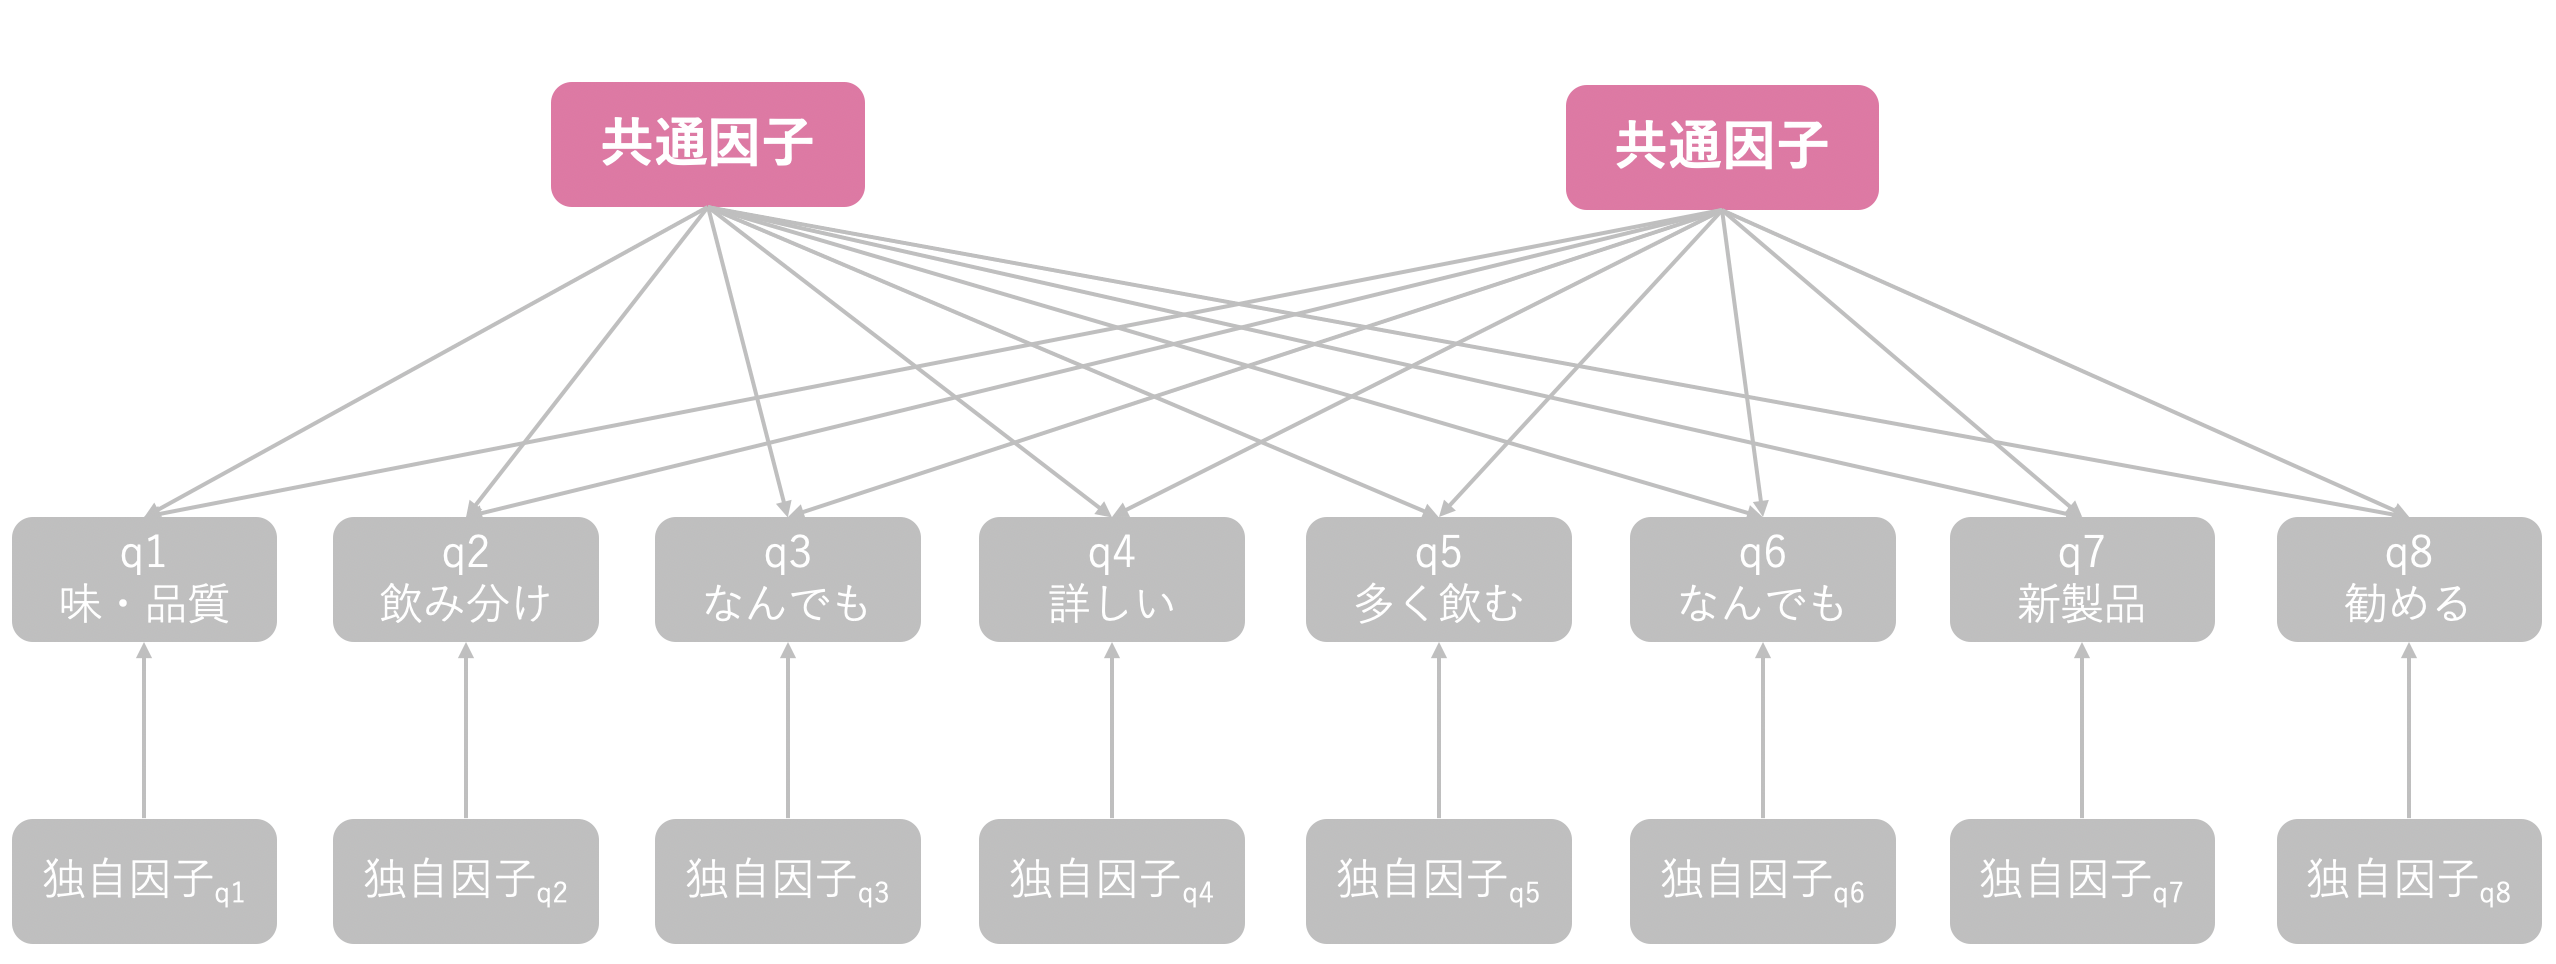


### 4.1. 因子分析で共通因子を特定する
#### 4.1.1. 相関行列から固有値を計算
因子分析では共通因子の数を決めるために，まず各アンケート項目の固有値を計算することが必要になります．この固有値は各アンケート項目間の相関を示す相関行列から算出されます．相関行列は```corr()```で計算されます．

In [62]:
cor = df_cluster.corr()
cor

,q1,q2,q3,q4,q5,q6,q7,q8
q1,1.000000,0.400336,-0.301706,0.544620,0.121534,-0.282283,0.421438,0.513293
q2,0.400336,1.000000,-0.151067,0.224655,0.013877,-0.237834,0.175100,0.134631
q3,-0.301706,-0.151067,1.000000,-0.387715,-0.116653,0.384017,-0.317856,-0.426762
q4,0.544620,0.224655,-0.387715,1.000000,0.491741,-0.388207,0.469048,0.530094
q5,0.121534,0.013877,-0.116653,0.491741,1.000000,-0.210096,0.318093,0.326229
q6,-0.282283,-0.237834,0.384017,-0.388207,-0.210096,1.000000,-0.205128,-0.447006
q7,0.421438,0.175100,-0.317856,0.469048,0.318093,-0.205128,1.000000,0.627111
q8,0.513293,0.134631,-0.426762,0.530094,0.326229,-0.447006,0.627111,1.000000


では，相関行列から固有値を計算していきます．ここでの固有値とは，各因子の全てのアンケート項目に対する支配度を示しています．つまり固有値が大きいものほど，情報量のある因子ということになります．因子はそれぞれの項目の数だけ存在するので，固有値は8つ出力されるはずです．

In [63]:
# 必要なライブラリのインポート
import numpy as np
from numpy import linalg as LA
# 相関行列から固有値の算出
eigenv = LA.eigvals(cor)
eigenv

array([3.41851795, 1.1350158 , 0.26678993, 0.32952034, 0.90127797,
       0.81554794, 0.54940744, 0.58392262])

#### 4.1.2. 共通因子の数を決める
今回はスクリープロットという方法で因子の数を決めていきます．固有値をプロットしてみて，ガクッと下がっている数あるいは1を下回る数が最適な因子の数です．```matplotlib```ライブラリの```plot()```コマンドでグラフを作成出来ます．```hlines()```で横方向の直線を引くことが出来ます。```hlines()```の詳しい説明は[こちら](http://nekoyukimmm.hatenablog.com/entry/2015/11/07/130817)から．

初めて```japanize_matplotlib```を使用する人でAnaconda環境の場合は[このサイト](https://ai-inter1.com/matplotlib-japanize/)の**japanize_matplotlibの利用による日本語対応**を参考にして設定してみてください．ダイレクトにPythonの環境を作っている人はターミナルあるいはコマンドプロンプトで```pip install japanize-matplotlib```とうってください。

Text(0, 0.5, 'fixed value')

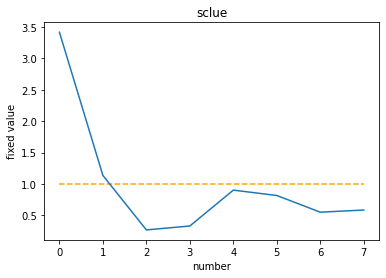

In [65]:
plt.plot(eigenv)
plt.hlines([1], 0, 7, 'orange', linestyles='dashed')
plt.title('sclue')
plt.xlabel('number')
plt.ylabel('fixed value')

因子の数は2,3個が良さげですね。今回は2個でやってみます。

#### 4.1.3. 因子分析をして，共通因子の特徴を把握
やっと因子分析です！各アンケート項目に対して因子負荷量を計算していきます．因子負荷量は各項目がどの程度因子の影響を受けているかを表しています．```FactorAnalyzer```を使うと因子分析をすることが出来ます．```n_factors```で共通因子の数を，```rotation```で回転の方法を指定します．anaconda環境の人は```conda install -c desilinguist factor_analyzer```をanaconda promptで実行してみてください．

まずはpromax回転で分析してみます．

In [66]:
# データの正規化
from sklearn.preprocessing import scale
df_scaled = scale(df_cluster)

from factor_analyzer import FactorAnalyzer
# 今回の因子分析の設定をする．まずはpromax回転で分析してみます．
fa_promax =FactorAnalyzer(n_factors=2, rotation='promax')
# データに対して因子分析を実行！
fa_promax.fit(df_scaled)
# 因子負荷量を出力
fa_promax.loadings_

array([[ 0.11404993,  0.70853406],
       [-0.16223966,  0.59217587],
       [-0.31714585, -0.25182165],
       [ 0.67832717,  0.15631595],
       [ 0.73717791, -0.32989187],
       [-0.32121646, -0.24641772],
       [ 0.57250581,  0.12730107],
       [ 0.67158003,  0.18417186]])

因子負荷量を可視化して，それぞれの因子がどのような要素を含んでいるのか検討していきます。

In [69]:
column = df_cluster.columns
result_promax = pd.DataFrame(fa_promax.loadings_, index = column, columns = ["Factor1_promax","Factor2_promax"])
result_promax.style.background_gradient(cmap=cm4)

,Factor1_promax,Factor2_promax
q1,0.114050,0.708534
q2,-0.162240,0.592176
q3,-0.317146,-0.251822
q4,0.678327,0.156316
q5,0.737178,-0.329892
q6,-0.321216,-0.246418
q7,0.572506,0.127301
q8,0.671580,0.184172


＜再掲＞

- q1 味や、品質にこだわる
- q2 ときと場合により、飲みわける
- q3 気に入ったブランドはない
- q4 人よりよく知っている
- q5 ひとより多く飲む
- q6 特に気にしない
- q7 新製品が出ると試してみる
- q8 好きなブランドを人に勧めることがある

＜共通因子の命名＞
- Factor1は市場への敏感さ因
- Factor2はこだわり因子？？

#### 4.1.4. それぞれの顧客に対して因子得点を算出する
```transform```で各商品の因子得点を出力することが出来ます．

In [70]:
score_promax = fa_promax.transform(df_scaled)
score_promax

array([[ 0.99316966,  0.79053618],
       [-0.6965445 ,  0.18806705],
       [ 2.66808333,  1.1734536 ],
       [-0.06164614,  0.08846632],
       [-0.39989343,  0.06341862],
       [-1.21843876, -0.54374452],
       [-0.30127944, -0.44611412],
       [-0.37465518,  0.25689996],
       [-0.68493444, -0.06737872],
       [ 0.25860516,  0.39902271],
       [-0.4475157 , -0.80429933],
       [ 1.84834667,  1.4323844 ],
       [ 1.59815788,  1.36374446],
       [-0.42763859, -0.74111694],
       [ 0.08431457, -1.48711936],
       [-0.57010394, -0.83494784],
       [ 0.14553858, -0.18461002],
       [-0.25451133, -0.27270209],
       [ 0.251061  , -0.13336572],
       [ 1.17284327,  1.06803533],
       [ 1.22836089,  1.48015647],
       [ 0.18256929,  1.11238049],
       [-1.31341708,  0.3730157 ],
       [-0.25925056, -0.24446215],
       [-0.16778807,  0.4527723 ],
       [-0.09441681, -0.10881117],
       [-0.16109807,  0.29085481],
       [-0.42243068,  0.01057993],
       [ 0.49198711,

In [71]:
df_promax = pd.DataFrame(score_promax, columns = ["Factor1_promax", "Factor2_promax"])
df_promax.head()

,Factor1_promax,Factor2_promax
0,0.993170,0.790536
1,-0.696545,0.188067
2,2.668083,1.173454
3,-0.061646,0.088466
4,-0.399893,0.063419


### 4.2. 因子得点でクラスター分析を実行する
#### 4.2.1. クラスター数:4

In [72]:
# クラスター分析の設定をkm2に格納
km_pro_4 = KMeans(n_clusters=4,random_state=2)

# クラスタリング
score_promax_pred_4 = km_pro_4.fit_predict(score_promax)
score_promax_pred_4

array([0, 1, 2, 1, 1, 3, 1, 1, 1, 0, 3, 2, 2, 3, 3, 3, 1, 1, 1, 2, 2, 0,
       1, 1, 1, 1, 1, 1, 0, 3, 3, 0, 3, 0, 1, 1, 1, 3, 3, 1, 0, 3, 0, 0,
       0, 2, 0, 3, 2, 2, 0, 0, 2, 1, 3, 2, 0, 1, 3, 0, 1, 3, 3, 1, 1, 0,
       2, 1, 3, 0, 1, 1, 1, 1, 3, 1, 1, 2, 3, 0], dtype=int32)

In [73]:
df = pd.concat([df, df_promax], axis = 1)
df.head()

,ID,q1,q2,q3,q4,q5,q6,q7,q8,F1,F2,F3,cluster,Factor1_promax,Factor2_promax
0,1,4,4,2,3,2,2,4,4,6,2,5,0,0.993170,0.790536
1,2,5,3,5,3,1,5,1,1,2,1,4,2,-0.696545,0.188067
2,3,5,1,1,5,4,1,5,5,5,1,2,0,2.668083,1.173454
3,4,4,4,3,2,3,3,3,2,2,2,3,2,-0.061646,0.088466
4,5,4,4,5,2,2,2,2,2,4,2,3,2,-0.399893,0.063419


In [74]:
df['cluster_id_pro_4'] = score_promax_pred_4
df.head()

,ID,q1,q2,q3,q4,q5,q6,q7,q8,F1,F2,F3,cluster,Factor1_promax,Factor2_promax,cluster_id_pro_4
0,1,4,4,2,3,2,2,4,4,6,2,5,0,0.993170,0.790536,0
1,2,5,3,5,3,1,5,1,1,2,1,4,2,-0.696545,0.188067,1
2,3,5,1,1,5,4,1,5,5,5,1,2,0,2.668083,1.173454,2
3,4,4,4,3,2,3,3,3,2,2,2,3,2,-0.061646,0.088466,1
4,5,4,4,5,2,2,2,2,2,4,2,3,2,-0.399893,0.063419,1


In [75]:
df['cluster_id_pro_4'].value_counts()

1    31
3    19
0    18
2    12
Name: cluster_id_pro_4, dtype: int64

今回は2つの項目(Factor1とFactor2)でクラスタリングしているので，可視化することが出来ます！

/Users/k.fukada/.local/share/virtualenvs/data_science-tXjswaqR/lib/python3.8/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


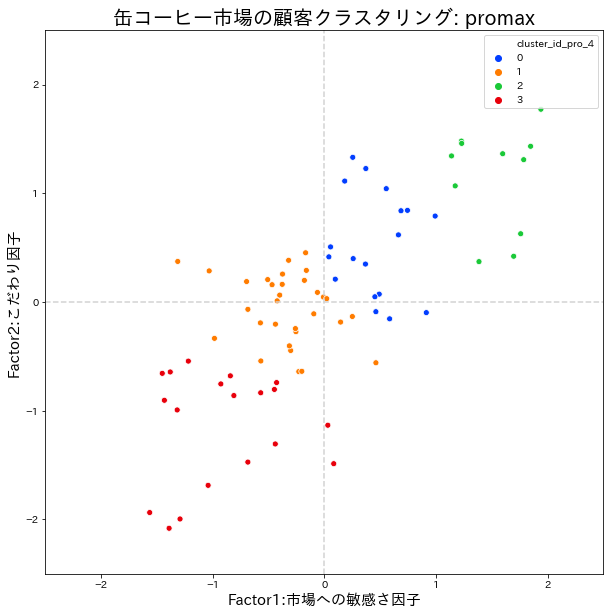

In [77]:
import japanize_matplotlib
plt.figure(figsize=(10, 10))
sns.scatterplot(data = df, x = "Factor1_promax", y = "Factor2_promax", hue = "cluster_id_pro_4", palette='bright')
plt.xlabel('Factor1:市場への敏感さ因子',size = 15)
plt.ylabel('Factor2:こだわり因子',size = 15)
plt.title('缶コーヒー市場の顧客クラスタリング: promax',size = 20)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.hlines([0], -2.5, 2.5, 'lightgray', linestyles='dashed')
plt.vlines([0], -2.5, 2.5, 'lightgray', linestyles='dashed')

#### 4.2.2. クラスター数:3

In [78]:
# クラスター分析の設定をkm3に格納
km_pro_3 = KMeans(n_clusters=3,random_state=2)

# クラスタリング
score_promax_pred_3 = km_pro_3.fit_predict(score_promax)

df['cluster_id_pro_3'] = score_promax_pred_3
df.head()

,ID,q1,q2,q3,q4,q5,q6,q7,q8,F1,F2,F3,cluster,Factor1_promax,Factor2_promax,cluster_id_pro_4,cluster_id_pro_3
0,1,4,4,2,3,2,2,4,4,6,2,5,0,0.993170,0.790536,0,2
1,2,5,3,5,3,1,5,1,1,2,1,4,2,-0.696545,0.188067,1,0
2,3,5,1,1,5,4,1,5,5,5,1,2,0,2.668083,1.173454,2,2
3,4,4,4,3,2,3,3,3,2,2,2,3,2,-0.061646,0.088466,1,0
4,5,4,4,5,2,2,2,2,2,4,2,3,2,-0.399893,0.063419,1,0


In [79]:
df['cluster_id_pro_3'].value_counts()

0    39
1    21
2    20
Name: cluster_id_pro_3, dtype: int64

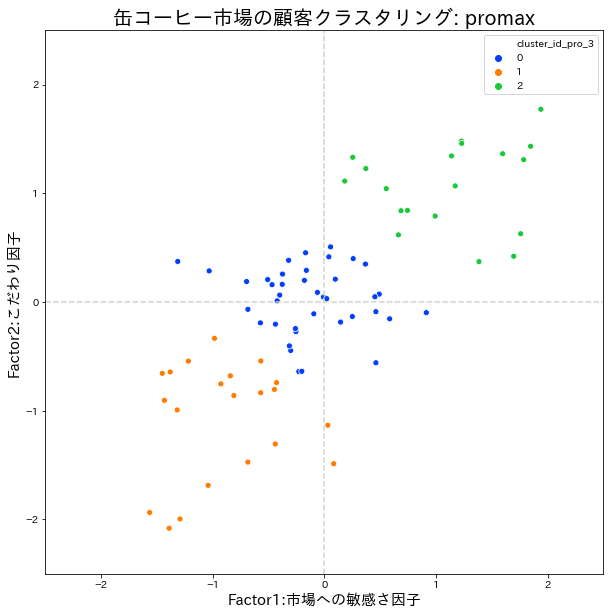

In [80]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data = df, x = "Factor1_promax", y = "Factor2_promax", hue = "cluster_id_pro_3", palette='bright')
plt.xlabel('Factor1:市場への敏感さ因子',size = 15)
plt.ylabel('Factor2:こだわり因子',size = 15)
plt.title('缶コーヒー市場の顧客クラスタリング: promax',size = 20)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.hlines([0], -2.5, 2.5, 'lightgray', linestyles='dashed')
plt.vlines([0], -2.5, 2.5, 'lightgray', linestyles='dashed')

#### 4.2.3. バリマックス回転も試してみる

In [ ]:
fa_varimax =FactorAnalyzer(n_factors=2, rotation='varimax')
fa_varimax.fit(df_scaled)
result_varimax = pd.DataFrame(fa_varimax.loadings_, index = column, columns = ["Factor1","Factor2"])
result_varimax.style.background_gradient(cmap=cm)

In [ ]:
score_varimax = fa_varimax.transform(df_scaled)

df_varimax = pd.DataFrame(score_varimax, columns = ["Factor1_varimax", "Factor2_varimax"])

# クラスター分析の設定をkm3に格納
km_vari_4 = KMeans(n_clusters=4,random_state=4)

# クラスタリング
score_varimax_pred_4 = km_vari_4.fit_predict(score_varimax)

df['cluster_id_vari_4'] = score_varimax_pred_4

df = pd.concat([df, df_varimax], axis = 1)
df.head()

In [ ]:
df['cluster_id_vari_4'].value_counts()

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data = df, x = "Factor1_varimax", y = "Factor2_varimax", hue = "cluster_id_vari_4", palette='bright')
plt.xlabel('Factor1:市場への敏感さ因子',size = 15)
plt.ylabel('Factor2:こだわり因子',size = 15)
plt.title('缶コーヒー市場の顧客クラスタリング: varimax',size = 20)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.hlines([0], -2.5, 2.5, 'lightgray', linestyles='dashed')
plt.vlines([0], -2.5, 2.5, 'lightgray', linestyles='dashed')